In [1]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.plotting import imshow

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity, rstest_twosided
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-neuro/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
# params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
# params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [6]:
signCells = SignificantCells('significant_cells_maintenance.h5')
signCellsMouseDict = signCells.get_cells_by_mouse()
signCellsMouseDict

{'m060': array([16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 61, 62, 63, 65,
        66, 67, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85,
        87]),
 'm061': array([ 7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 24, 28, 29, 30, 31, 32,
        33, 35, 36, 37, 38, 39, 40, 41, 44]),
 'm065': array([13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 51, 69,
        71, 72, 73, 74, 77, 78, 79, 80, 82]),
 'm066': array([ 6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        41, 42, 44, 45, 46]),
 'm067': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 47, 48]),
 'm068': array([ 9, 10, 12, 13, 14, 15, 16, 23, 24, 25, 26])}

# 1. Neuron-Time-Average

**Goal**: Attempt to predict L/R and C/M from mean activity over trial

**VERY IMPORTANT**: When we compare significant cells, we must compare exactly the same cells in each condition. So, we must select all cells significant within that interval/phase

5 performance True


,mouse,Correct,Mistake,nTrials,nNeurons,-log10(pval)
0,m060,0.064430,0.063333,"(133, 20)",52,0.078348
1,m061,0.094749,0.094411,"(74, 16)",26,0.001832
2,m065,0.153552,0.156903,"(181, 57)",43,0.133287
3,m066,0.151631,0.161357,"(151, 37)",22,0.350529
4,m067,0.097056,0.096111,"(154, 43)",38,0.095334
5,m068,0.107939,0.094431,"(175, 63)",11,1.265669


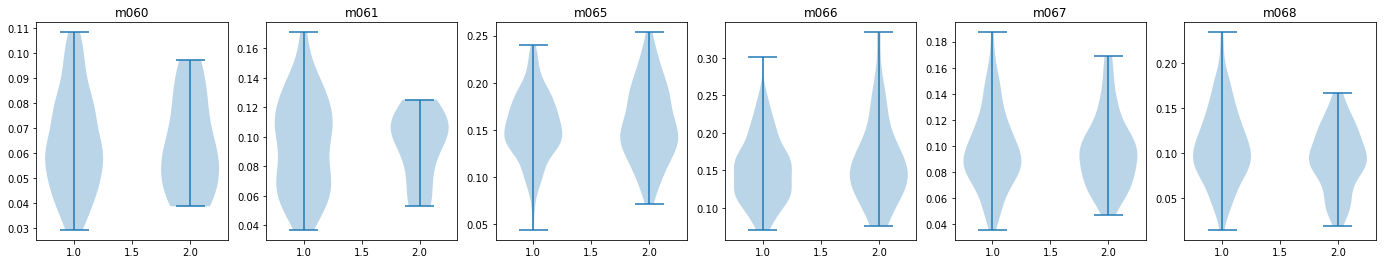

5 performance False


,mouse,Correct,Mistake,nTrials,nNeurons,-log10(pval)
0,m060,0.064430,0.063333,"(133, 20)",88,0.078348
1,m061,0.094749,0.094411,"(74, 16)",46,0.001832
2,m065,0.153552,0.156903,"(181, 57)",83,0.133287
3,m066,0.151631,0.161357,"(151, 37)",47,0.350529
4,m067,0.097056,0.096111,"(154, 43)",49,0.095334
5,m068,0.107939,0.094431,"(175, 63)",28,1.265669


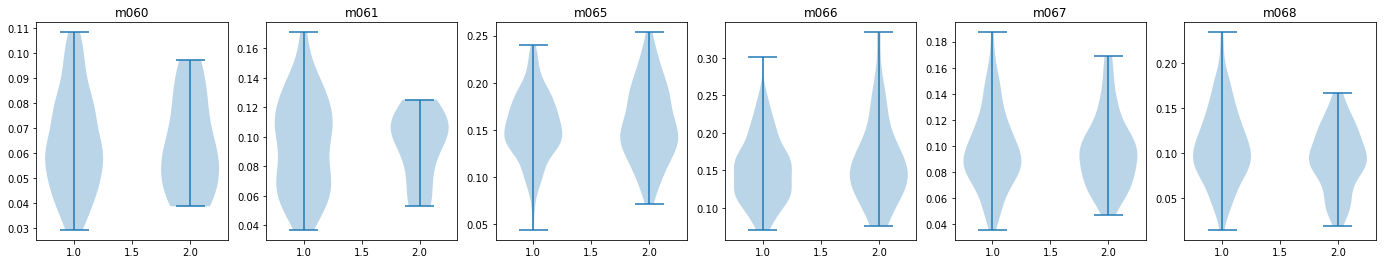

5 direction True


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.065041,0.063481,"(79, 74)",52,0.272763
1,m061,0.102270,0.087108,"(45, 45)",26,1.550266
2,m065,0.143658,0.165604,"(122, 116)",43,5.344125
3,m066,0.158323,0.149516,"(86, 102)",22,0.494606
4,m067,0.098734,0.095265,"(90, 107)",38,0.666142
5,m068,0.103560,0.105267,"(126, 112)",11,0.104224


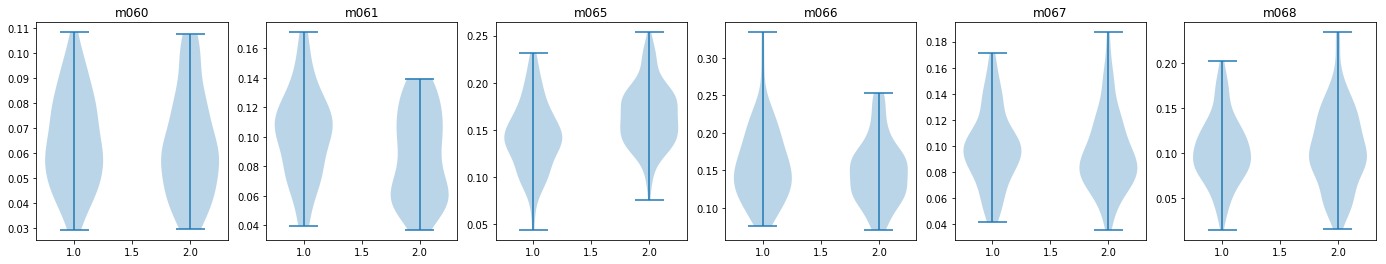

5 direction False


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.065041,0.063481,"(79, 74)",88,0.272763
1,m061,0.102270,0.087108,"(45, 45)",46,1.550266
2,m065,0.143658,0.165604,"(122, 116)",83,5.344125
3,m066,0.158323,0.149516,"(86, 102)",47,0.494606
4,m067,0.098734,0.095265,"(90, 107)",49,0.666142
5,m068,0.103560,0.105267,"(126, 112)",28,0.104224


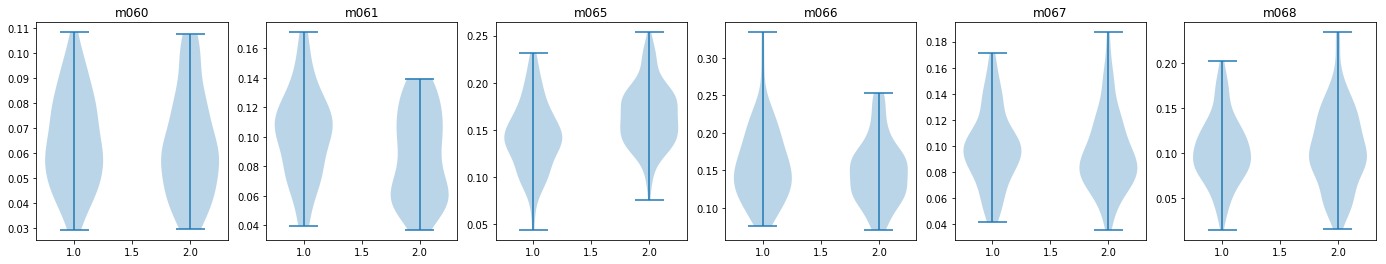

6 performance True


,mouse,Correct,Mistake,nTrials,nNeurons,-log10(pval)
0,m060,0.073979,0.075503,"(133, 20)",52,0.160667
1,m061,0.143932,0.141038,"(74, 16)",26,0.090280
2,m065,0.141582,0.137644,"(181, 57)",43,0.447987
3,m066,0.140928,0.137054,"(151, 37)",22,0.313996
4,m067,0.124652,0.123965,"(154, 43)",38,0.050358
5,m068,0.101307,0.099494,"(175, 63)",11,0.134082


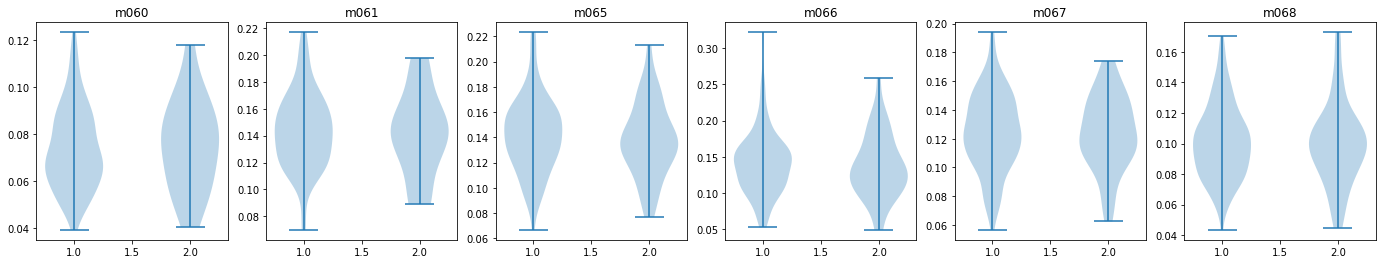

6 performance False


,mouse,Correct,Mistake,nTrials,nNeurons,-log10(pval)
0,m060,0.073979,0.075503,"(133, 20)",88,0.160667
1,m061,0.143932,0.141038,"(74, 16)",46,0.090280
2,m065,0.141582,0.137644,"(181, 57)",83,0.447987
3,m066,0.140928,0.137054,"(151, 37)",47,0.313996
4,m067,0.124652,0.123965,"(154, 43)",49,0.050358
5,m068,0.101307,0.099494,"(175, 63)",28,0.134082


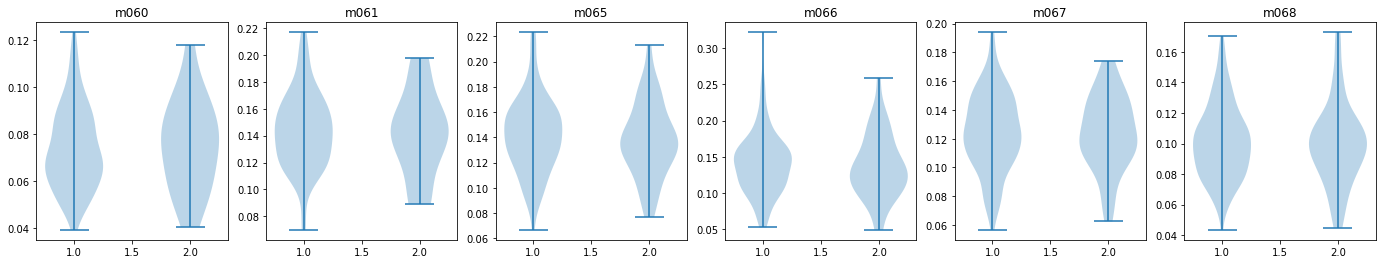

6 direction True


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.076582,0.071611,"(79, 74)",52,1.329563
1,m061,0.142524,0.144311,"(45, 45)",26,0.126763
2,m065,0.137388,0.144058,"(122, 116)",43,0.916053
3,m066,0.138814,0.141305,"(86, 102)",22,0.128567
4,m067,0.126129,0.123133,"(90, 107)",38,0.410234
5,m068,0.101112,0.100508,"(126, 112)",11,0.090761


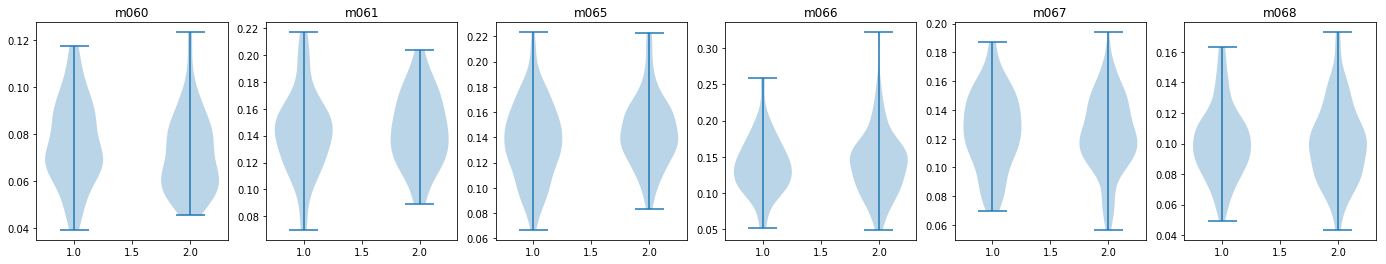

6 direction False


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.076582,0.071611,"(79, 74)",88,1.329563
1,m061,0.142524,0.144311,"(45, 45)",46,0.126763
2,m065,0.137388,0.144058,"(122, 116)",83,0.916053
3,m066,0.138814,0.141305,"(86, 102)",47,0.128567
4,m067,0.126129,0.123133,"(90, 107)",49,0.410234
5,m068,0.101112,0.100508,"(126, 112)",28,0.090761


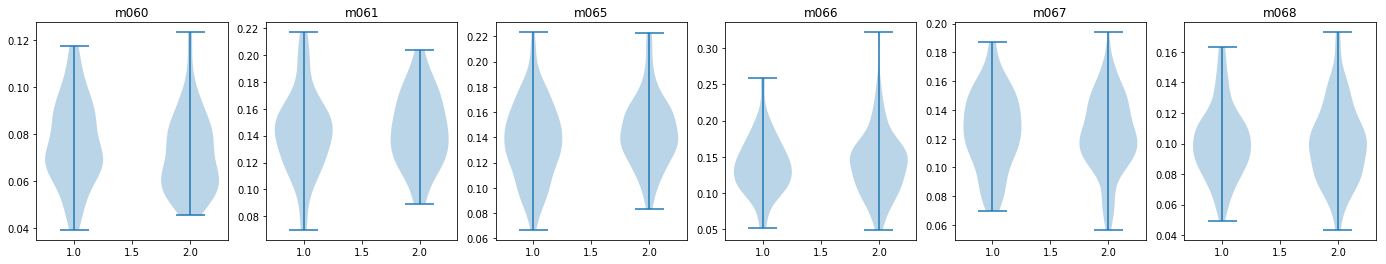

7 performance True


,mouse,Correct,Mistake,nTrials,nNeurons,-log10(pval)
0,m060,0.067818,0.064418,"(133, 20)",52,0.207304
1,m061,0.129478,0.123713,"(74, 16)",26,0.346299
2,m065,0.119012,0.106991,"(181, 57)",43,3.038972
3,m066,0.131057,0.127017,"(151, 37)",22,0.372306
4,m067,0.125279,0.125133,"(154, 43)",38,0.034291
5,m068,0.099095,0.093009,"(175, 63)",11,0.947567


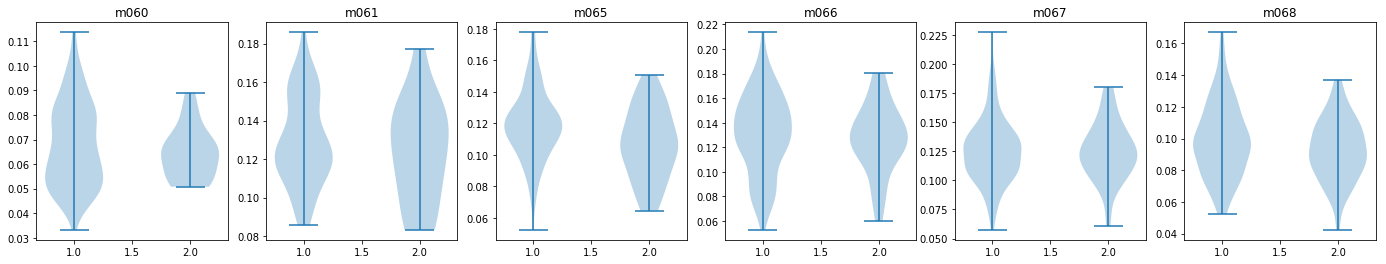

7 performance False


,mouse,Correct,Mistake,nTrials,nNeurons,-log10(pval)
0,m060,0.067818,0.064418,"(133, 20)",88,0.207304
1,m061,0.129478,0.123713,"(74, 16)",46,0.346299
2,m065,0.119012,0.106991,"(181, 57)",83,3.038972
3,m066,0.131057,0.127017,"(151, 37)",47,0.372306
4,m067,0.125279,0.125133,"(154, 43)",49,0.034291
5,m068,0.099095,0.093009,"(175, 63)",28,0.947567


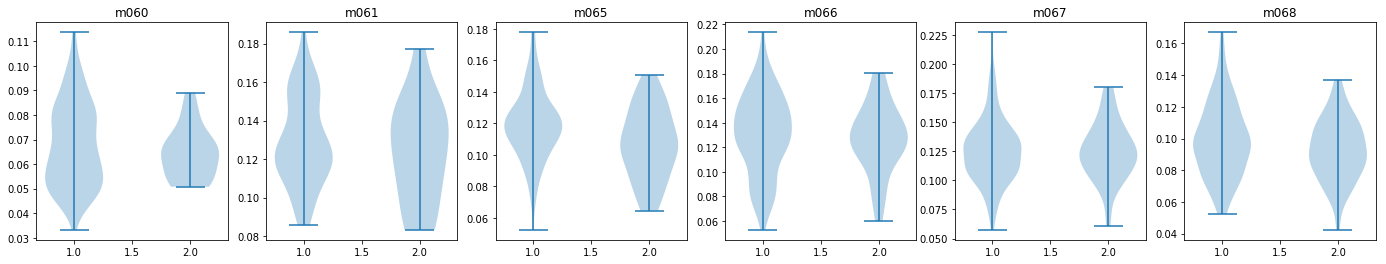

7 direction True


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.068750,0.065904,"(79, 74)",52,0.485514
1,m061,0.126476,0.130430,"(45, 45)",26,0.377078
2,m065,0.114227,0.118137,"(122, 116)",43,0.818120
3,m066,0.131687,0.129060,"(86, 102)",22,0.255838
4,m067,0.124811,0.125613,"(90, 107)",38,0.012789
5,m068,0.095609,0.099593,"(126, 112)",11,0.706289


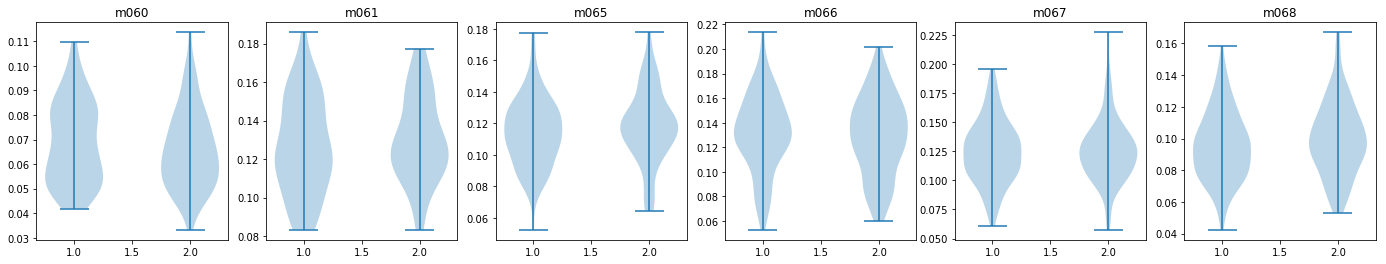

7 direction False


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.068750,0.065904,"(79, 74)",88,0.485514
1,m061,0.126476,0.130430,"(45, 45)",46,0.377078
2,m065,0.114227,0.118137,"(122, 116)",83,0.818120
3,m066,0.131687,0.129060,"(86, 102)",47,0.255838
4,m067,0.124811,0.125613,"(90, 107)",49,0.012789
5,m068,0.095609,0.099593,"(126, 112)",28,0.706289


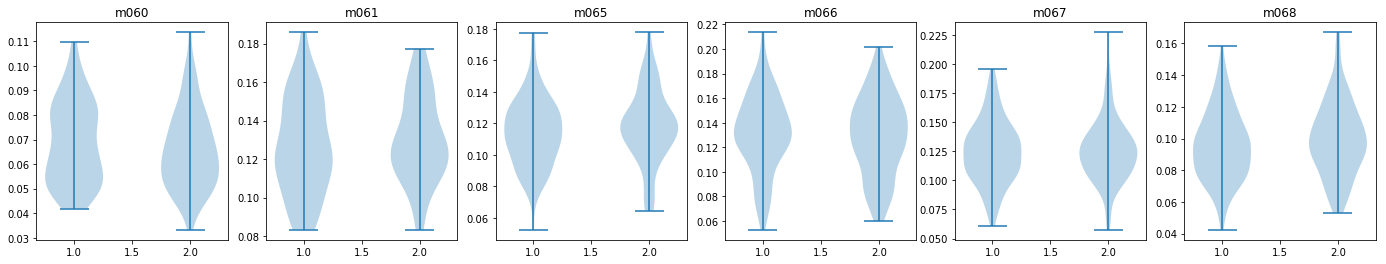

In [10]:
def test_mean_time_and_neurons(dataDB, datatype, selector, condition, useSignificant=False):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    testResults = []
    
    fig, ax = plt.subplots(ncols=nMice, figsize=(4*nMice, 4))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        
        if useSignificant:
            channelFilter = signCellsMouseDict
            nChannels = len(signCellsMouseDict[mousename])
        else:
            channelFilter = None
            nChannels = dataDB.get_nchannel(mousename, datatype)
            
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "r", selector, {}, channelFilter=signCellsMouseDict)]

        meanVals = [np.mean(mu) for mu in means]
        nTrialsCond = tuple(len(mu) for mu in means)
        negLogPVal = -np.log10(rstest_twosided(*means)[1])
        
                
        testResults += [[mousename, *meanVals, nTrialsCond, nChannels, negLogPVal]]
        ax[iMouse].violinplot(means)
        ax[iMouse].set_title(mousename)
        
    display(pd.DataFrame(testResults, columns=["mouse", *condValues, "nTrials", "nNeurons", "-log10(pval)"]))
    plt.show()
    

for interval in range(5, 8):
    for condition in ["performance", "direction"]:
        for useSignificant in [True, False]:
    #         print(condition, useSignificant)
            print(interval, condition, useSignificant)
#         test_mean_time_and_neurons(dataDB, "deconv", {"phase" : "Maintenance"}, condition, useSignificant=useSignificant)
            test_mean_time_and_neurons(dataDB, "deconv", {"interval" : interval}, condition, useSignificant=useSignificant)


# 2 Time-Average

**Goal**: Attempt to predict LR/CM from average activities of individual cells.
* Count predictive cells in each mouse, phase/interval

No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,52,-0.00
1,m061,0,26,-0.00
2,m065,1,43,0.45
3,m066,0,22,-0.00
4,m067,0,38,-0.00
5,m068,0,11,0.00


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


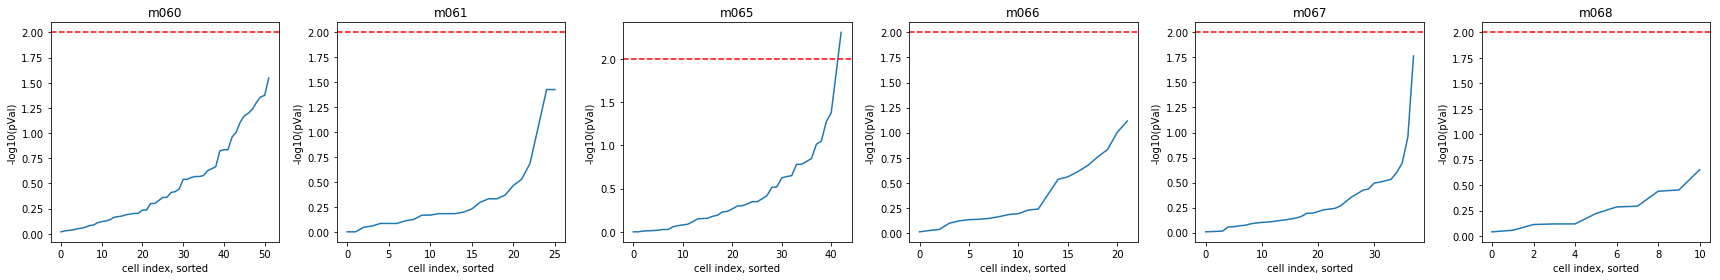

In [25]:
def test_mean_time(dataDB, queryDict, selector, condition, nTest=1000, pval=0.01, useSignificant=False):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig1, ax1 = plt.subplots(ncols=nMice, figsize=(4*nMice, 4), tight_layout=True)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        
        if useSignificant:
            channelFilter = signCellsMouseDict
            nCells = len(signCellsMouseDict[mousename])
        else:
            channelFilter = None
            nCells = dataDB.get_nchannel(mousename, queryDict['datatype'])
        
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "pr", selector, {}, channelFilter=channelFilter)]
            
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval)
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 2)]]
        
        ax1[iMouse].plot(sorted(-np.log10(pValByCell)))
        ax1[iMouse].axhline(y=2, linestyle="--", color='r')
        ax1[iMouse].set_xlabel("cell index, sorted")
        ax1[iMouse].set_ylabel("-log10(pVal)")
        ax1[iMouse].set_title(mousename)
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
        
    plt.show()
    
    
# queryDict = {"datatype" : "raw", "performance" : "Correct"}
queryDict = {"datatype" : "raw", "direction" : "R"}
test_mean_time(dataDB, queryDict, {"interval" : 7}, "performance", useSignificant=True)
#test_mean_time(dataDB, queryDict, {"phase" : "Maintenance"}, "direction")

Calculating mouse m060
Calculating mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; 

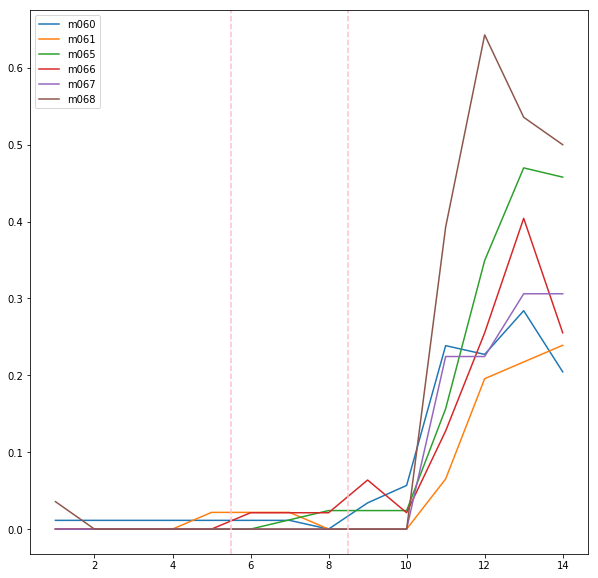

In [29]:
def test_ncells_by_interval(dataDB, queryDict, condition, intervRange, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(figsize=(10,10))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Calculating mouse", mousename)
        
        freqCellSignificant = []
        for iInterv in intervRange:
            selector = {"interval" : iInterv}
        
            means = []
            for condVal in condValues:        
                queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
                means += [metric_by_selector(dataDB, queryDictCond, "mean", "pr", selector, {})]

            nCells = means[0].shape[0]
            _, nCellSignificant, _ = test_quantity(means[0], means[1], pval)
            freqCellSignificant += [nCellSignificant / nCells]
            
        ax.plot(np.array(intervRange)+1, freqCellSignificant, label=mousename)

    ax.axvline(x=5.5, linestyle='--', color='pink')
    ax.axvline(x=8.5, linestyle='--', color='pink')
    plt.legend()
    plt.savefig('interval_freq_significant_cells_'+condition+'.pdf')
    plt.show()
    
queryDict = {"datatype" : "raw", "direction" : "R"}
# queryDict = {"datatype" : "raw", "performance" : "Correct"}
test_ncells_by_interval(dataDB, queryDict, "performance", range(0, 14))

## 2.3 Significant Cell Confusion matrices

In [13]:
def text_different_one(data2D, i):
    dataThis = data2D[i]
    dataOther = np.hstack(data2D[:i] + data2D[i+1:])
    T, p = rstest_twosided(dataThis, dataOther)
    return -np.log10(p)


def text_different(data2D):
    return np.array([text_different_one(data2D, i) for i in range(len(data2D))])


# Calculate confusion matrix
def significance_confusion_matrix(sign2D):
    nCell, nPhase = sign2D.shape  # A boolean array reporting if a given cell is significant in a given phase
    confMat = np.zeros((nPhase, nPhase))
    for i in range(nPhase):
        for j in range(nPhase):
            confMat[i][j] = np.sum(np.logical_and(sign2D[:, i], sign2D[:, j]))
    return confMat

def confusion_matrices_LRCM(queryDict, selector):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 4), tight_layout=True)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print('doing mouse', mousename)

        keys = []
        rezLst = []
        for performance in ['Correct', 'Mistake']:
            for direction in ['L', 'R']:
                keys += [str((performance, direction))]
                queryDictThis = {**queryDict, **{'mousename' : mousename, 'performance' : performance, 'direction' : direction}}
                rezLst += [metric_by_selector(dataDB, queryDictThis, 'mean', 'pr', selector, settings)]
                
        nChannel = len(rezLst[0])
        pVals2D = np.array([text_different([rez[iCh] for rez in rezLst]) for iCh in range(nChannel)])

        # Calculate confusion matrix
        sign2D = pVals2D > 2
        confMat = significance_confusion_matrix(sign2D)

        # Plot confusion matrix
        imshow(fig, ax[iMouse], confMat, limits=[0, nChannel], title=mousename, haveColorBar=True, cmap='jet',
               haveTicks=True, xTicks=keys, yTicks=keys)

    fig.savefig('interval_'+ str(selector["interval"] + 1) +'_significant_cells_confusion.pdf')
    #plt.show()
    plt.close()

In [14]:
for iInterv in range(4, 9):
    confusion_matrices_LRCM({"datatype" : "deconv"}, {"interval" : iInterv})

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour 

# 3. Scalar metric tests

**Goal**: Evaluate predictive power for several metrics
* Stretch hypothesis: Legendre Basis (try several bases individually up to 6)
* Synchronization hypothesis: AvgCorr, H

## Table

In [40]:
%%time
dataDB.verbose = False

#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
sweepDict = {
    "datatype": ["deconv"],
    "performance": ["Correct", "Mistake", "All"],
#     "direction": ["L", "R", "All"]
}
# selector = {"phase" : "Maintenance"}
selector = {"interval" : 9}

table_lib.table_discriminate_behavior(dataDB, selector, "direction",
                                      sweepDict,
                                      "mean",
                                      trgDimOrder="r",
                                      settings=settings,
                                      multiplexKey="mousename",
                                      channelFilter=None)

,-logp(L->R),datatype,mu(L),mu(R),performance
0,2.796041,deconv,0.089443,0.087178,Correct
1,0.352504,deconv,0.090626,0.088738,Mistake
2,1.653204,deconv,0.089676,0.087409,All


CPU times: user 521 ms, sys: 0 ns, total: 521 ms
Wall time: 520 ms


## Violins

For ('Correct', 'Mistake') of data size (434, 114) rank-sum-test is 0.0007104739231471268


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


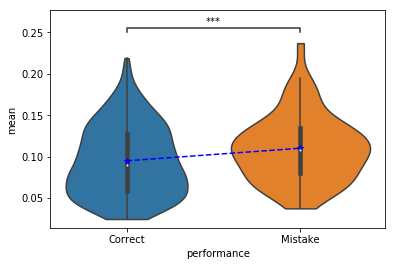

In [20]:
def binary_test_phase(dataDB, queryDict, condition, selector, metricName, settings):
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    
    rezLst = []
    for condVal in condValues:
        queryDictCond = {**queryDict, **{condition : condVal}}
        rezLst += [metric_by_selector(dataDB, queryDictCond, metricName, "r", selector, {})]
        
    fig, ax = plt.subplots()
    plots_lib.plot_labeled_violins(ax, rezLst, condValues, condition, metricName,
                                   joinMeans=True, haveLog=False, sigTestPairs=[(0,1)])
    
    
#settings = {"serial" : True, "metricSettings" : {"metric" : num_sample}}
settings = {"serial" : True, "metricSettings" : {}}
queryDict = {"datatype" : "deconv", "direction" : "L"}

binary_test_phase(dataDB, queryDict, "performance", {"interval" : 8}, "mean", settings)
#binary_test_phase(dataDB, queryDict, "direction", ["L", "R"], "Maintenance", settings)

# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

In [3]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"serial": True, "metricSettings": None}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings)

rez

NameError: name 'plots_lib' is not defined

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)